In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   

                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l3_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l3_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 372221 records
valid has 49086 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1532
0
26 32 (1, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1532/1532 [==============================] - 20s 13ms/step - loss: 0.2842 - total_loss: 0.2842 - reg_loss: 0.2842 - val_loss: 0.2574 - val_total_loss: 0.2574 - val_reg_loss: 0.2574
Epoch 2/100
1532/1532 [==============================] - 18s 12ms/step - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938690 -0.009580  0.230306    7  2017-04-16
472     2.507290  2.521050 -0.013760  0.230927    1  2017-04-17
473     2.661330  2.666697 -0.005367  0.248989    2  2017-04-18
474     2.754815  2.761225 -0.006411  0.204673    3  2017-04-19
475     2.713762  2.725923 -0.012161  0.235044    4  2017-04-20
476     2.999000  2.989756  0.009244  0.154727    5  2017-04-21
477     3.075529  3.087709 -0.012180  0.186044    6  2017-04-22

0.212958507173
best_epochs [4, 5, 3, 8, 9]
(829, 1) 2.68051065761 

2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195972, 2) (49031, 2)
train/valid # (195972, 2) (49031, 2)
rand split across time
train has 195972 records out of 372221 records
valid has 49031 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1531
0
26 32 (2, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1531/1531 [==============================] - 19s 12ms/step - loss: 0.2996 - total_loss: 0.2996 - reg_loss: 0.2996 - val_loss: 0.2638 - val_total_loss: 0.2638 - val_reg_loss: 0.2638
Epoch 2/100
1531/1531 [==============================] - 19s 12ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.930566 -0.001456  0.233140    6  2017-04-15
471     2.507290  2.554612 -0.047321  0.232302    7  2017-04-16
472     2.661330  2.685691 -0.024362  0.243185    1  2017-04-17
473     2.754815  2.739998  0.014816  0.213069    2  2017-04-18
474     2.713762  2.714595 -0.000833  0.232976    3  2017-04-19
475     2.999000  2.991123  0.007876  0.153568    4  2017-04-20
476     3.075529  3.087680 -0.012150  0.182633    5  2017-04-21

0.212981959444
best_epochs [4, 5, 8, 7, 6]
(829, 1) 2.50886342775 

3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195805, 2) (48983, 2)
train/valid # (195805, 2) (48983, 2)
rand split across time
train has 195805 records out of 372221 records
valid has 48983 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1529
0
26 32 (3, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1529/1529 [==============================] - 19s 12ms/step - loss: 0.2972 - total_loss: 0.2972 - reg_loss: 0.2972 - val_loss: 0.2581 - val_total_loss: 0.2581 - val_reg_loss: 0.2581
Epoch 2/100
1529/1529 [==============================] - 19s 12ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.882409  0.046701  0.236561    5  2017-04-14
470     2.507290  2.531632 -0.024341  0.234924    6  2017-04-15
471     2.661330  2.628484  0.032846  0.255179    7  2017-04-16
472     2.754815  2.734284  0.020531  0.206657    1  2017-04-17
473     2.713762  2.701720  0.012041  0.236784    2  2017-04-18
474     2.999000  2.969133  0.029866  0.158236    3  2017-04-19
475     3.075529  3.063476  0.012053  0.187971    4  2017-04-20

0.216616011454
best_epochs [4, 5, 6, 8, 7]
(829, 1) 2.60004206326 

4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195621, 2) (48937, 2)
train/valid # (195621, 2) (48937, 2)
rand split across time
train has 195621 records out of 372221 records
valid has 48937 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1528
0
26 32 (4, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1528/1528 [==============================] - 25s 16ms/step - loss: 0.3018 - total_loss: 0.3018 - reg_loss: 0.3018 - val_loss: 0.2621 - val_total_loss: 0.2621 - val_reg_loss: 0.2621
Epoch 2/100
1528/1528 [==============================] - 24s 16ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.904747  0.024363  0.243300    4  2017-04-13
469     2.507290  2.544509 -0.037219  0.237019    5  2017-04-14
470     2.661330  2.658946  0.002383  0.254820    6  2017-04-15
471     2.754815  2.729870  0.024945  0.214474    7  2017-04-16
472     2.713762  2.711740  0.002021  0.233328    1  2017-04-17
473     2.999000  2.987947  0.011053  0.160418    2  2017-04-18
474     3.075529  3.070653  0.004876  0.184649    3  2017-04-19

0.218286846371
best_epochs [8, 3, 4, 5, 7]
(829, 1) 2.71100491217 

5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 14.8043
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195402, 2) (48885, 2)
train/valid # (195402, 2) (48885, 2)
rand split across time
train has 195402 records out of 372221 records
valid has 48885 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1526
0
26 32 (5, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1526/1526 [==============================] - 22s 14ms/step - loss: 0.3012 - total_loss: 0.3012 - reg_loss: 0.3012 - val_loss: 0.2732 - val_total_loss: 0.2732 - val_reg_loss: 0.2732
Epoch 2/100
1526/1526 [==============================] - 21s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.903270  0.025840  0.239183    3  2017-04-12
468     2.507290  2.518232 -0.010941  0.241242    4  2017-04-13
469     2.661330  2.633529  0.027801  0.261486    5  2017-04-14
470     2.754815  2.738811  0.016004  0.212350    6  2017-04-15
471     2.713762  2.702468  0.011294  0.238056    7  2017-04-16
472     2.999000  2.992501  0.006498  0.161086    1  2017-04-17
473     3.075529  3.088799 -0.013269  0.182788    2  2017-04-18

0.219455752722
best_epochs [4, 3, 7, 9, 5]
(829, 1) 2.70355932829 

6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 15.1334
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (195183, 2) (48836, 2)
train/valid # (195183, 2) (48836, 2)
rand split across time
train has 195183 records out of 372221 records
valid has 48836 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1524
0
26 32 (6, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1524/1524 [==============================] - 22s 14ms/step - loss: 0.3010 - total_loss: 0.3010 - reg_loss: 0.3010 - val_loss: 0.2650 - val_total_loss: 0.2650 - val_reg_loss: 0.2650
Epoch 2/100
1524/1524 [==============================] - 22s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.920988  0.008122  0.245981    2  2017-04-11
467     2.507290  2.562321 -0.055030  0.248491    3  2017-04-12
468     2.661330  2.653636  0.007694  0.266764    4  2017-04-13
469     2.754815  2.747840  0.006975  0.214592    5  2017-04-14
470     2.713762  2.732095 -0.018333  0.244968    6  2017-04-15
471     2.999000  3.000689 -0.001690  0.163801    7  2017-04-16
472     3.075529  3.101075 -0.025546  0.187791    1  2017-04-17

0.224626809952
best_epochs [3, 4, 7, 6, 5]
(829, 1) 3.04316596833 

7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 16.3101
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194956, 2) (48782, 2)
train/valid # (194956, 2) (48782, 2)
rand split across time
train has 194956 records out of 372221 records
valid has 48782 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1523
0
26 32 (7, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074 - val_loss: 0.2725 - val_total_loss: 0.2725 - val_reg_loss: 0.2725
Epoch 2/100
1523/1523 [==============================] - 21s 14ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.890922  0.038188  0.234732    1  2017-04-10
466     2.507290  2.540541 -0.033250  0.246978    2  2017-04-11
467     2.661330  2.636903  0.024426  0.262716    3  2017-04-12
468     2.754815  2.730339  0.024476  0.213067    4  2017-04-13
469     2.713762  2.735242 -0.021480  0.243768    5  2017-04-14
470     2.999000  2.982100  0.016900  0.159317    6  2017-04-15
471     3.075529  3.112043 -0.036514  0.187597    7  2017-04-16

0.221167805098
best_epochs [4, 6, 9, 5, 2]
(829, 1) 2.97433682572 

8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 17.5743
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194719, 2) (48724, 2)
train/valid # (194719, 2) (48724, 2)
rand split across time
train has 194719 records out of 372221 records
valid has 48724 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1521
0
26 32 (8, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1521/1521 [==============================] - 24s 16ms/step - loss: 0.3436 - total_loss: 0.3436 - reg_loss: 0.3436 - val_loss: 0.3042 - val_total_loss: 0.3042 - val_reg_loss: 0.3042
Epoch 2/100
1521/1521 [==============================] - 24s 15ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.915665  0.013445  0.243352    7  2017-04-09
465     2.507290  2.538308 -0.031017  0.241521    1  2017-04-10
466     2.661330  2.648893  0.012437  0.272506    2  2017-04-11
467     2.754815  2.747782  0.007033  0.224784    3  2017-04-12
468     2.713762  2.728992 -0.015231  0.250061    4  2017-04-13
469     2.999000  2.998374  0.000625  0.166037    5  2017-04-14
470     3.075529  3.110389 -0.034860  0.188004    6  2017-04-15

0.226609355502
best_epochs [3, 5, 7, 6, 2]
(829, 1) 2.77267724046 

9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 18.8065
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194492, 2) (48667, 2)
train/valid # (194492, 2) (48667, 2)
rand split across time
train has 194492 records out of 372221 records
valid has 48667 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1519
0
26 32 (9, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1519/1519 [==============================] - 25s 16ms/step - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080 - val_loss: 0.2820 - val_total_loss: 0.2820 - val_reg_loss: 0.2820
Epoch 2/100
1519/1519 [==============================] - 23s 15ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.892491  0.036619  0.255705    6  2017-04-08
464     2.507290  2.548681 -0.041390  0.242614    7  2017-04-09
465     2.661330  2.654106  0.007223  0.267043    1  2017-04-10
466     2.754815  2.738905  0.015910  0.224308    2  2017-04-11
467     2.713762  2.718430 -0.004669  0.242538    3  2017-04-12
468     2.999000  2.984981  0.014019  0.167323    4  2017-04-13
469     3.075529  3.089031 -0.013501  0.190601    5  2017-04-14

0.227161705391
best_epochs [9, 6, 5, 4, 7]
(829, 1) 2.55249995911 

10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 19.9265
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194327, 2) (48623, 2)
train/valid # (194327, 2) (48623, 2)
rand split across time
train has 194327 records out of 372221 records
valid has 48623 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1518
0
26 32 (10, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1518/1518 [==============================] - 21s 14ms/step - loss: 0.3085 - total_loss: 0.3085 - reg_loss: 0.3085 - val_loss: 0.2875 - val_total_loss: 0.2875 - val_reg_loss: 0.2875
Epoch 2/100
1518/1518 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.907943  0.021167  0.250647    5  2017-04-07
463     2.507290  2.514603 -0.007313  0.242663    6  2017-04-08
464     2.661330  2.668758 -0.007428  0.270716    7  2017-04-09
465     2.754815  2.724972  0.029843  0.221873    1  2017-04-10
466     2.713762  2.719227 -0.005465  0.246590    2  2017-04-11
467     2.999000  2.994312  0.004687  0.167616    3  2017-04-12
468     3.075529  3.092372 -0.016842  0.187992    4  2017-04-13

0.226871066417
best_epochs [3, 4, 6, 8, 7]
(829, 1) 2.67164974154 

11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 21.0577
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194133, 2) (48577, 2)
train/valid # (194133, 2) (48577, 2)
rand split across time
train has 194133 records out of 372221 records
valid has 48577 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1516
0
26 32 (11, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1516/1516 [==============================] - 24s 16ms/step - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127 - val_loss: 0.2898 - val_total_loss: 0.2898 - val_reg_loss: 0.2898
Epoch 2/100
1516/1516 [==============================] - 22s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.877684  0.051426  0.245744    4  2017-04-06
462     2.507290  2.542528 -0.035238  0.240345    5  2017-04-07
463     2.661330  2.653663  0.007667  0.268924    6  2017-04-08
464     2.754815  2.696907  0.057908  0.225695    7  2017-04-09
465     2.713762  2.709908  0.003853  0.243937    1  2017-04-10
466     2.999000  2.988392  0.010608  0.169721    2  2017-04-11
467     3.075529  3.086690 -0.011161  0.187752    3  2017-04-12

0.226016990341
best_epochs [7, 4, 6, 10, 3]
(829, 1) 2.99803479262 

12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 22.1151
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193913, 2) (48524, 2)
train/valid # (193913, 2) (48524, 2)
rand split across time
train has 193913 records out of 372221 records
valid has 48524 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1514
0
26 32 (12, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1514/1514 [==============================] - 21s 14ms/step - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127 - val_loss: 0.2979 - val_total_loss: 0.2979 - val_reg_loss: 0.2979
Epoch 2/100
1514/1514 [==============================] - 21s 14ms/

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.888076  0.041034  0.252615    3  2017-04-05
461     2.507290  2.545991 -0.038700  0.243559    4  2017-04-06
462     2.661330  2.697866 -0.036537  0.272398    5  2017-04-07
463     2.754815  2.741833  0.012982  0.226171    6  2017-04-08
464     2.713762  2.712561  0.001200  0.241250    7  2017-04-09
465     2.999000  2.985271  0.013729  0.167651    1  2017-04-10
466     3.075529  3.075821 -0.000292  0.192116    2  2017-04-11

0.227965752872
best_epochs [7, 6, 3, 2, 4]
(829, 1) 3.05696103378 

13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 23.1552
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193685, 2) (48474, 2)
train/valid # (193685, 2) (48474, 2)
rand split across time
train has 193685 records out of 372221 records
valid has 48474 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1513
0
26 32 (13, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1513/1513 [==============================] - 22s 14ms/step - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153 - val_loss: 0.2846 - val_total_loss: 0.2846 - val_reg_loss: 0.2846
Epoch 2/100
1513/1513 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.934164 -0.005054  0.256819    2  2017-04-04
460     2.507290  2.559293 -0.052003  0.255653    3  2017-04-05
461     2.661330  2.677746 -0.016416  0.276493    4  2017-04-06
462     2.754815  2.767368 -0.012553  0.229653    5  2017-04-07
463     2.713762  2.751240 -0.037478  0.254138    6  2017-04-08
464     2.999000  2.989458  0.009542  0.166646    7  2017-04-09
465     3.075529  3.092169 -0.016640  0.190752    1  2017-04-10

0.232879185148
best_epochs [5, 3, 4, 7, 6]
(829, 1) 3.13223464819 

14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 24.2264
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193472, 2) (48423, 2)
train/valid # (193472, 2) (48423, 2)
rand split across time
train has 193472 records out of 372221 records
valid has 48423 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1511
0
26 32 (14, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1511/1511 [==============================] - 21s 14ms/step - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156 - val_loss: 0.2890 - val_total_loss: 0.2890 - val_reg_loss: 0.2890
Epoch 2/100
1511/1511 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.876271  0.052839  0.255472    1  2017-04-03
459     2.507290  2.532461 -0.025171  0.246643    2  2017-04-04
460     2.661330  2.654150  0.007180  0.273487    3  2017-04-05
461     2.754815  2.723955  0.030860  0.232873    4  2017-04-06
462     2.713762  2.692727  0.021034  0.250505    5  2017-04-07
463     2.999000  2.999987 -0.000988  0.164484    6  2017-04-08
464     3.075529  3.043597  0.031932  0.192357    7  2017-04-09

0.230831752387
best_epochs [4, 5, 6, 2, 3]
(829, 1) 3.05020478634 

15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 25.3577
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193241, 2) (48367, 2)
train/valid # (193241, 2) (48367, 2)
rand split across time
train has 193241 records out of 372221 records
valid has 48367 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1509
0
26 32 (15, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1509/1509 [==============================] - 24s 16ms/step - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 0.3199 - val_loss: 0.2849 - val_total_loss: 0.2849 - val_reg_loss: 0.2849
Epoch 2/100
1509/1509 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.900828  0.028282  0.258517    7  2017-04-02
458     2.507290  2.515086 -0.007795  0.245523    1  2017-04-03
459     2.661330  2.671073 -0.009744  0.284926    2  2017-04-04
460     2.754815  2.697680  0.057135  0.230418    3  2017-04-05
461     2.713762  2.709892  0.003869  0.252635    4  2017-04-06
462     2.999000  2.979524  0.019476  0.168970    5  2017-04-07
463     3.075529  3.075939 -0.000410  0.193171    6  2017-04-08

0.233451530532
best_epochs [4, 3, 7, 6, 2]
(829, 1) 2.70797513186 

16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 26.4659
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193006, 2) (48312, 2)
train/valid # (193006, 2) (48312, 2)
rand split across time
train has 193006 records out of 372221 records
valid has 48312 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1507
0
26 32 (16, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1507/1507 [==============================] - 24s 16ms/step - loss: 0.3208 - total_loss: 0.3208 - reg_loss: 0.3208 - val_loss: 0.3041 - val_total_loss: 0.3041 - val_reg_loss: 0.3041
Epoch 2/100
1507/1507 [==============================] - 23s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.890921  0.038189  0.268210    6  2017-04-01
457     2.507290  2.532561 -0.025270  0.242053    7  2017-04-02
458     2.661330  2.655981  0.005349  0.279788    1  2017-04-03
459     2.754815  2.697827  0.056987  0.234617    2  2017-04-04
460     2.713762  2.690637  0.023124  0.253409    3  2017-04-05
461     2.999000  2.970158  0.028841  0.174638    4  2017-04-06
462     3.075529  3.051150  0.024380  0.194305    5  2017-04-07

0.235288716269
best_epochs [4, 6, 7, 3, 5]
(829, 1) 2.56905828911 

17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 27.6058
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192838, 2) (48266, 2)
train/valid # (192838, 2) (48266, 2)
rand split across time
train has 192838 records out of 372221 records
valid has 48266 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1506
0
26 32 (17, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1506/1506 [==============================] - 24s 16ms/step - loss: 0.3220 - total_loss: 0.3220 - reg_loss: 0.3220 - val_loss: 0.2888 - val_total_loss: 0.2888 - val_reg_loss: 0.2888
Epoch 2/100
1506/1506 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.883545  0.045565  0.261380    5  2017-03-31
456     2.507290  2.496899  0.010392  0.249312    6  2017-04-01
457     2.661330  2.622622  0.038707  0.279925    7  2017-04-02
458     2.754815  2.663527  0.091287  0.245551    1  2017-04-03
459     2.713762  2.660099  0.053663  0.257821    2  2017-04-04
460     2.999000  2.953699  0.045301  0.177833    3  2017-04-05
461     3.075529  3.020211  0.055319  0.194778    4  2017-04-06

0.238085775287
best_epochs [5, 3, 7, 9, 6]
(829, 1) 2.5940961394 

18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 28.7513
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192649, 2) (48219, 2)
train/valid # (192649, 2) (48219, 2)
rand split across time
train has 192649 records out of 372221 records
valid has 48219 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1505
0
26 32 (18, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1505/1505 [==============================] - 24s 16ms/step - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242 - val_loss: 0.2961 - val_total_loss: 0.2961 - val_reg_loss: 0.2961
Epoch 2/100
1505/1505 [==============================] - 23s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.906908  0.022202  0.267325    4  2017-03-30
455     2.507290  2.534235 -0.026944  0.251430    5  2017-03-31
456     2.661330  2.625847  0.035483  0.287037    6  2017-04-01
457     2.754815  2.729551  0.025263  0.233969    7  2017-04-02
458     2.713762  2.734635 -0.020873  0.260346    1  2017-04-03
459     2.999000  2.990990  0.008010  0.176499    2  2017-04-04
460     3.075529  3.040820  0.034710  0.196202    3  2017-04-05

0.238972557686
best_epochs [6, 5, 3, 7, 2]
(829, 1) 2.76002065239 

19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 29.7986
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192437, 2) (48166, 2)
train/valid # (192437, 2) (48166, 2)
rand split across time
train has 192437 records out of 372221 records
valid has 48166 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1503
0
26 32 (19, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1503/1503 [==============================] - 24s 16ms/step - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233 - val_loss: 0.2999 - val_total_loss: 0.2999 - val_reg_loss: 0.2999
Epoch 2/100
1503/1503 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.939028 -0.009918  0.265584    3  2017-03-29
454     2.507290  2.536479 -0.029189  0.255200    4  2017-03-30
455     2.661330  2.626592  0.034738  0.282266    5  2017-03-31
456     2.754815  2.726360  0.028455  0.238817    6  2017-04-01
457     2.713762  2.725968 -0.012206  0.254738    7  2017-04-02
458     2.999000  2.976682  0.022318  0.177752    1  2017-04-03
459     3.075529  3.063952  0.011577  0.194479    2  2017-04-04

0.23840511928
best_epochs [3, 4, 6, 5, 7]
(829, 1) 2.7206812871 

20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 30.7963
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192218, 2) (48118, 2)
train/valid # (192218, 2) (48118, 2)
rand split across time
train has 192218 records out of 372221 records
valid has 48118 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1501
0
26 32 (20, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1501/1501 [==============================] - 23s 16ms/step - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237 - val_loss: 0.3249 - val_total_loss: 0.3249 - val_reg_loss: 0.3249
Epoch 2/100
1501/1501 [==============================] - 23s 15ms/ste

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.941593 -0.012484  0.256159    2  2017-03-28
453     2.507290  2.569464 -0.062173  0.248357    3  2017-03-29
454     2.661330  2.662846 -0.001516  0.274557    4  2017-03-30
455     2.754815  2.717750  0.037065  0.235283    5  2017-03-31
456     2.713762  2.714472 -0.000710  0.259808    6  2017-04-01
457     2.999000  2.988625  0.010375  0.171559    7  2017-04-02
458     3.075529  3.095845 -0.020316  0.191269    1  2017-04-03

0.233856038606
best_epochs [5, 3, 7, 4, 9]
(829, 1) 2.97676918741 

21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 31.7929
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192004, 2) (48064, 2)
train/valid # (192004, 2) (48064, 2)
rand split across time
train has 192004 records out of 372221 records
valid has 48064 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1500
0
26 32 (21, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1500/1500 [==============================] - 23s 16ms/step - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298 - val_loss: 0.2976 - val_total_loss: 0.2976 - val_reg_loss: 0.2976
Epoch 2/100
1500/1500 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.868636  0.060474  0.277152    1  2017-03-27
452     2.507290  2.515454 -0.008163  0.258366    2  2017-03-28
453     2.661330  2.630550  0.030779  0.288196    3  2017-03-29
454     2.754815  2.690870  0.063945  0.243568    4  2017-03-30
455     2.713762  2.686383  0.027379  0.265475    5  2017-03-31
456     2.999000  2.937888  0.061112  0.187414    6  2017-04-01
457     3.075529  3.036676  0.038853  0.198401    7  2017-04-02

0.245510377839
best_epochs [3, 5, 4, 6, 2]
(829, 1) 3.01818901627 

22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 32.871
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191773, 2) (48006, 2)
train/valid # (191773, 2) (48006, 2)
rand split across time
train has 191773 records out of 372221 records
valid has 48006 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1498
0
26 32 (22, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1498/1498 [==============================] - 23s 16ms/step - loss: 0.3293 - total_loss: 0.3293 - reg_loss: 0.3293 - val_loss: 0.3056 - val_total_loss: 0.3056 - val_reg_loss: 0.3056
Epoch 2/100
1498/1498 [==============================] - 23s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.914561  0.014549  0.259338    7  2017-03-26
451     2.507290  2.535058 -0.027767  0.249940    1  2017-03-27
452     2.661330  2.637940  0.023389  0.284844    2  2017-03-28
453     2.754815  2.721669  0.033146  0.235801    3  2017-03-29
454     2.713762  2.719077 -0.005315  0.261511    4  2017-03-30
455     2.999000  2.977887  0.021113  0.183116    5  2017-03-31
456     3.075529  3.066375  0.009154  0.193765    6  2017-04-01

0.23833071972
best_epochs [6, 3, 5, 4, 8]
(829, 1) 2.72285370512 

23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 33.9745
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191540, 2) (47949, 2)
train/valid # (191540, 2) (47949, 2)
rand split across time
train has 191540 records out of 372221 records
valid has 47949 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1496
0
26 32 (23, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1496/1496 [==============================] - 24s 16ms/step - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316 - val_loss: 0.3043 - val_total_loss: 0.3043 - val_reg_loss: 0.3043
Epoch 2/100
1496/1496 [==============================] - 23s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.911336  0.017774  0.266455    6  2017-03-25
450     2.507290  2.533941 -0.026650  0.252816    7  2017-03-26
451     2.661330  2.633950  0.027380  0.281829    1  2017-03-27
452     2.754815  2.709501  0.045314  0.243516    2  2017-03-28
453     2.713762  2.726487 -0.012726  0.265997    3  2017-03-29
454     2.999000  2.976939  0.022061  0.185105    4  2017-03-30
455     3.075529  3.060945  0.014585  0.192149    5  2017-03-31

0.241123855411
best_epochs [3, 6, 4, 5, 1]
(829, 1) 2.48819254801 

24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 35.2084
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191372, 2) (47903, 2)
train/valid # (191372, 2) (47903, 2)
rand split across time
train has 191372 records out of 372221 records
valid has 47903 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1495
0
26 32 (24, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1495/1495 [==============================] - 21s 14ms/step - loss: 0.3311 - total_loss: 0.3311 - reg_loss: 0.3311 - val_loss: 0.3023 - val_total_loss: 0.3023 - val_reg_loss: 0.3023
Epoch 2/100
1495/1495 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.920151  0.008959  0.260680    5  2017-03-24
449     2.507290  2.548918 -0.041628  0.254829    6  2017-03-25
450     2.661330  2.672798 -0.011468  0.275432    7  2017-03-26
451     2.754815  2.743183  0.011632  0.229488    1  2017-03-27
452     2.713762  2.730061 -0.016299  0.260445    2  2017-03-28
453     2.999000  2.983094  0.015906  0.178272    3  2017-03-29
454     3.075529  3.069742  0.005787  0.191125    4  2017-03-30

0.235752971597
best_epochs [3, 8, 7, 5, 4]
(829, 1) 2.6134766585 

25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 36.3351
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191188, 2) (47860, 2)
train/valid # (191188, 2) (47860, 2)
rand split across time
train has 191188 records out of 372221 records
valid has 47860 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1493
0
26 32 (25, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1493/1493 [==============================] - 21s 14ms/step - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321 - val_loss: 0.2995 - val_total_loss: 0.2995 - val_reg_loss: 0.2995
Epoch 2/100
1493/1493 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.898523  0.030587  0.265116    4  2017-03-23
448     2.507290  2.480326  0.026964  0.260748    5  2017-03-24
449     2.661330  2.612961  0.048369  0.283885    6  2017-03-25
450     2.754815  2.708089  0.046726  0.245681    7  2017-03-26
451     2.713762  2.699054  0.014708  0.265747    1  2017-03-27
452     2.999000  2.992846  0.006154  0.179848    2  2017-03-28
453     3.075529  3.069618  0.005911  0.196067    3  2017-03-29

0.242441786336
best_epochs [3, 4, 5, 6, 7]
(829, 1) 2.66305847686 

26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 37.3741
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190975, 2) (47809, 2)
train/valid # (190975, 2) (47809, 2)
rand split across time
train has 190975 records out of 372221 records
valid has 47809 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1491
0
26 32 (26, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1491/1491 [==============================] - 23s 16ms/step - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322 - val_loss: 0.3045 - val_total_loss: 0.3045 - val_reg_loss: 0.3045
Epoch 2/100
1491/1491 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.912383  0.016727  0.276909    3  2017-03-22
447     2.507290  2.536859 -0.029568  0.253751    4  2017-03-23
448     2.661330  2.686204 -0.024874  0.279311    5  2017-03-24
449     2.754815  2.732840  0.021975  0.238969    6  2017-03-25
450     2.713762  2.698674  0.015088  0.266064    7  2017-03-26
451     2.999000  2.980627  0.018373  0.178471    1  2017-03-27
452     3.075529  3.079656 -0.004127  0.194440    2  2017-03-28

0.241130749489
best_epochs [4, 3, 7, 6, 5]
(829, 1) 2.69444582989 

27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 38.4506
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190754, 2) (47757, 2)
train/valid # (190754, 2) (47757, 2)
rand split across time
train has 190754 records out of 372221 records
valid has 47757 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1490
0
26 32 (27, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1490/1490 [==============================] - 23s 16ms/step - loss: 0.3318 - total_loss: 0.3318 - reg_loss: 0.3318 - val_loss: 0.3000 - val_total_loss: 0.3000 - val_reg_loss: 0.3000
Epoch 2/100
1490/1490 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.902938  0.026172  0.270810    2  2017-03-21
446     2.507290  2.516401 -0.009111  0.257281    3  2017-03-22
447     2.661330  2.661741 -0.000412  0.277798    4  2017-03-23
448     2.754815  2.748489  0.006326  0.238328    5  2017-03-24
449     2.713762  2.702079  0.011683  0.265465    6  2017-03-25
450     2.999000  2.976596  0.022404  0.181108    7  2017-03-26
451     3.075529  3.065970  0.009559  0.194540    1  2017-03-27

0.240761507118
best_epochs [4, 6, 2, 7, 5]
(829, 1) 3.01946478968 

28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 39.4798
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190528, 2) (47703, 2)
train/valid # (190528, 2) (47703, 2)
rand split across time
train has 190528 records out of 372221 records
valid has 47703 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1488
0
26 32 (28, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1488/1488 [==============================] - 20s 14ms/step - loss: 0.3339 - total_loss: 0.3339 - reg_loss: 0.3339 - val_loss: 0.3211 - val_total_loss: 0.3211 - val_reg_loss: 0.3211
Epoch 2/100
1488/1488 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.905420  0.023690  0.275411    1  2017-03-20
445     2.507290  2.519933 -0.012642  0.257623    2  2017-03-21
446     2.661330  2.642878  0.018452  0.274715    3  2017-03-22
447     2.754815  2.683654  0.071161  0.243816    4  2017-03-23
448     2.713762  2.676234  0.037527  0.269317    5  2017-03-24
449     2.999000  2.958607  0.040392  0.180520    6  2017-03-25
450     3.075529  3.066316  0.009213  0.198851    7  2017-03-26

0.242893167764
best_epochs [4, 3, 7, 2, 8]
(829, 1) 3.07950308806 

29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 40.7934
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190291, 2) (47645, 2)
train/valid # (190291, 2) (47645, 2)
rand split across time
train has 190291 records out of 372221 records
valid has 47645 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1486
0
26 32 (29, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1486/1486 [==============================] - 21s 14ms/step - loss: 0.3393 - total_loss: 0.3393 - reg_loss: 0.3393 - val_loss: 0.3109 - val_total_loss: 0.3109 - val_reg_loss: 0.3109
Epoch 2/100
1486/1486 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.917448  0.011662  0.269247    7  2017-03-19
444     2.507290  2.544998 -0.037707  0.254345    1  2017-03-20
445     2.661330  2.675822 -0.014492  0.285686    2  2017-03-21
446     2.754815  2.756121 -0.001307  0.247080    3  2017-03-22
447     2.713762  2.737652 -0.023891  0.269262    4  2017-03-23
448     2.999000  2.989355  0.009644  0.182388    5  2017-03-24
449     3.075529  3.091778 -0.016249  0.202225    6  2017-03-25

0.244318888624
best_epochs [4, 5, 3, 6, 7]
(829, 1) 2.77492226664 

30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 41.9859
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190058, 2) (47587, 2)
train/valid # (190058, 2) (47587, 2)
rand split across time
train has 190058 records out of 372221 records
valid has 47587 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1484
0
26 32 (30, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1484/1484 [==============================] - 22s 15ms/step - loss: 0.3378 - total_loss: 0.3378 - reg_loss: 0.3378 - val_loss: 0.3349 - val_total_loss: 0.3349 - val_reg_loss: 0.3349
Epoch 2/100
1484/1484 [==============================] - 22s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.925463  0.003647  0.272895    6  2017-03-18
443     2.507290  2.540983 -0.033693  0.251578    7  2017-03-19
444     2.661330  2.638281  0.023048  0.285989    1  2017-03-20
445     2.754815  2.744414  0.010401  0.240350    2  2017-03-21
446     2.713762  2.709734  0.004028  0.263181    3  2017-03-22
447     2.999000  2.981744  0.017256  0.182098    4  2017-03-23
448     3.075529  3.061777  0.013753  0.198591    5  2017-03-24

0.242097324846
best_epochs [4, 5, 2, 6, 9]
(829, 1) 2.56465554596 

31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 43.2281
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189881, 2) (47536, 2)
train/valid # (189881, 2) (47536, 2)
rand split across time
train has 189881 records out of 372221 records
valid has 47536 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1483
0
26 32 (31, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1483/1483 [==============================] - 20s 14ms/step - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367 - val_loss: 0.3192 - val_total_loss: 0.3192 - val_reg_loss: 0.3192
Epoch 2/100
1483/1483 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.909051  0.020059  0.269247    5  2017-03-17
442     2.507290  2.510407 -0.003116  0.254691    6  2017-03-18
443     2.661330  2.621305  0.040025  0.288415    7  2017-03-19
444     2.754815  2.687690  0.067125  0.245219    1  2017-03-20
445     2.713762  2.689717  0.024045  0.264435    2  2017-03-21
446     2.999000  2.978287  0.020713  0.178064    3  2017-03-22
447     3.075529  3.065145  0.010385  0.199846    4  2017-03-23

0.242845483494
best_epochs [4, 6, 2, 5, 8]
(829, 1) 2.65279570224 

32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 44.4464
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189691, 2) (47493, 2)
train/valid # (189691, 2) (47493, 2)
rand split across time
train has 189691 records out of 372221 records
valid has 47493 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1481
0
26 32 (32, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1481/1481 [==============================] - 20s 14ms/step - loss: 0.3427 - total_loss: 0.3427 - reg_loss: 0.3427 - val_loss: 0.3122 - val_total_loss: 0.3122 - val_reg_loss: 0.3122
Epoch 2/100
1481/1481 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.917003  0.012106  0.269858    4  2017-03-16
441     2.507290  2.500247  0.007044  0.258161    5  2017-03-17
442     2.661330  2.628434  0.032895  0.287236    6  2017-03-18
443     2.754815  2.730958  0.023857  0.248432    7  2017-03-19
444     2.713762  2.707855  0.005907  0.265278    1  2017-03-20
445     2.999000  2.990671  0.008329  0.183835    2  2017-03-21
446     3.075529  3.080916 -0.005387  0.200536    3  2017-03-22

0.244762343192
best_epochs [3, 5, 7, 2, 1]
(829, 1) 2.76599315738 

33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 45.5115
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189476, 2) (47441, 2)
train/valid # (189476, 2) (47441, 2)
rand split across time
train has 189476 records out of 372221 records
valid has 47441 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1480
0
26 32 (33, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1480/1480 [==============================] - 19s 13ms/step - loss: 0.3450 - total_loss: 0.3450 - reg_loss: 0.3450 - val_loss: 0.3268 - val_total_loss: 0.3268 - val_reg_loss: 0.3268
Epoch 2/100
1480/1480 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.875441  0.053669  0.274904    3  2017-03-15
440     2.507290  2.514834 -0.007544  0.257039    4  2017-03-16
441     2.661330  2.627688  0.033642  0.282668    5  2017-03-17
442     2.754815  2.704038  0.050777  0.241448    6  2017-03-18
443     2.713762  2.706972  0.006790  0.260719    7  2017-03-19
444     2.999000  2.982622  0.016378  0.183832    1  2017-03-20
445     3.075529  3.079962 -0.004433  0.204252    2  2017-03-21

0.243551656563
best_epochs [4, 3, 6, 2, 5]
(829, 1) 2.73122585701 

34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 46.5688
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189257, 2) (47384, 2)
train/valid # (189257, 2) (47384, 2)
rand split across time
train has 189257 records out of 372221 records
valid has 47384 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1478
0
26 32 (34, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1478/1478 [==============================] - 20s 14ms/step - loss: 0.3408 - total_loss: 0.3408 - reg_loss: 0.3408 - val_loss: 0.3462 - val_total_loss: 0.3462 - val_reg_loss: 0.3462
Epoch 2/100
1478/1478 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.888234  0.040875  0.260728    2  2017-03-14
439     2.507290  2.524538 -0.017248  0.251949    3  2017-03-15
440     2.661330  2.649563  0.011767  0.282985    4  2017-03-16
441     2.754815  2.715583  0.039231  0.233839    5  2017-03-17
442     2.713762  2.694415  0.019347  0.257350    6  2017-03-18
443     2.999000  2.963675  0.035325  0.181894    7  2017-03-19
444     3.075529  3.061641  0.013888  0.194131    1  2017-03-20

0.237553680919
best_epochs [4, 8, 6, 3, 7]
(829, 1) 3.00361880771 

35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 47.4733
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189036, 2) (47327, 2)
train/valid # (189036, 2) (47327, 2)
rand split across time
train has 189036 records out of 372221 records
valid has 47327 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1476
0
26 32 (35, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1476/1476 [==============================] - 21s 14ms/step - loss: 0.3468 - total_loss: 0.3468 - reg_loss: 0.3468 - val_loss: 0.3163 - val_total_loss: 0.3163 - val_reg_loss: 0.3163
Epoch 2/100
1476/1476 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.879588  0.049522  0.268654    1  2017-03-13
438     2.507290  2.501707  0.005583  0.260327    2  2017-03-14
439     2.661330  2.665034 -0.003704  0.292770    3  2017-03-15
440     2.754815  2.745449  0.009366  0.247295    4  2017-03-16
441     2.713762  2.709829  0.003933  0.260925    5  2017-03-17
442     2.999000  2.986473  0.012526  0.182160    6  2017-03-18
443     3.075529  3.098314 -0.022785  0.197442    7  2017-03-19

0.244224794369
best_epochs [5, 4, 2, 6, 3]
(829, 1) 3.12220178338 

36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 48.7491
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188800, 2) (47268, 2)
train/valid # (188800, 2) (47268, 2)
rand split across time
train has 188800 records out of 372221 records
valid has 47268 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1475
0
26 32 (36, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1475/1475 [==============================] - 20s 13ms/step - loss: 0.3471 - total_loss: 0.3471 - reg_loss: 0.3471 - val_loss: 0.3125 - val_total_loss: 0.3125 - val_reg_loss: 0.3125
Epoch 2/100
1475/1475 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.883783  0.045327  0.275383    7  2017-03-12
437     2.507290  2.502489  0.004802  0.258899    1  2017-03-13
438     2.661330  2.635503  0.025826  0.291187    2  2017-03-14
439     2.754815  2.708184  0.046631  0.248895    3  2017-03-15
440     2.713762  2.708093  0.005669  0.275238    4  2017-03-16
441     2.999000  2.961687  0.037313  0.185248    5  2017-03-17
442     3.075529  3.055741  0.019788  0.209728    6  2017-03-18

0.249225565871
best_epochs [3, 4, 1, 5, 2]
(829, 1) 2.76828190075 

37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 49.8797
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188568, 2) (47213, 2)
train/valid # (188568, 2) (47213, 2)
rand split across time
train has 188568 records out of 372221 records
valid has 47213 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1473
0
26 32 (37, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1473/1473 [==============================] - 21s 14ms/step - loss: 0.3473 - total_loss: 0.3473 - reg_loss: 0.3473 - val_loss: 0.3211 - val_total_loss: 0.3211 - val_reg_loss: 0.3211
Epoch 2/100
1473/1473 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.866812  0.062298  0.277914    6  2017-03-11
436     2.507290  2.519609 -0.012319  0.253039    7  2017-03-12
437     2.661330  2.623746  0.037584  0.281539    1  2017-03-13
438     2.754815  2.715686  0.039129  0.244648    2  2017-03-14
439     2.713762  2.694694  0.019067  0.264849    3  2017-03-15
440     2.999000  2.955694  0.043306  0.183873    4  2017-03-16
441     3.075529  3.072782  0.002747  0.206515    5  2017-03-17

0.24462539948
best_epochs [5, 2, 4, 8, 7]
(829, 1) 2.58922255301 

38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 51.0865
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188400, 2) (47162, 2)
train/valid # (188400, 2) (47162, 2)
rand split across time
train has 188400 records out of 372221 records
valid has 47162 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1471
0
26 32 (38, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1471/1471 [==============================] - 20s 14ms/step - loss: 0.3461 - total_loss: 0.3461 - reg_loss: 0.3461 - val_loss: 0.3222 - val_total_loss: 0.3222 - val_reg_loss: 0.3222
Epoch 2/100
1471/1471 [==============================] - 19s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.885603  0.043507  0.284253    5  2017-03-10
435     2.507290  2.539817 -0.032527  0.259050    6  2017-03-11
436     2.661330  2.650550  0.010780  0.289230    7  2017-03-12
437     2.754815  2.727951  0.026864  0.245803    1  2017-03-13
438     2.713762  2.702941  0.010821  0.268984    2  2017-03-14
439     2.999000  2.950474  0.048526  0.187589    3  2017-03-15
440     3.075529  3.058414  0.017116  0.207310    4  2017-03-16

0.248888380189
best_epochs [4, 6, 3, 5, 8]
(829, 1) 2.67325608058 

39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.0676983 52.0488
(829, 517, 32)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188215, 2) (47116, 2)
train/valid # (188215, 2) (47116, 2)
rand split across time
train has 188215 records out of 372221 records
valid has 47116 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1470
0
26 32 (39, 32)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
381441
Epoch 1/100
1470/1470 [==============================] - 20s 14ms/step - loss: 0.3480 - total_loss: 0.3480 - reg_loss: 0.3480 - val_loss: 0.3202 - val_total_loss: 0.3202 - val_reg_loss: 0.3202
Epoch 2/100
1470/1470 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.899118  0.029992  0.278400    4  2017-03-09
434     2.507290  2.487590  0.019700  0.257143    5  2017-03-10
435     2.661330  2.640987  0.020343  0.284530    6  2017-03-11
436     2.754815  2.708862  0.045952  0.248062    7  2017-03-12
437     2.713762  2.700544  0.013217  0.272209    1  2017-03-13
438     2.999000  2.950000  0.049000  0.187195    2  2017-03-14
439     3.075529  3.069167  0.006362  0.204530    3  2017-03-15

0.247438512524
best_epochs [3, 5, 4, 2, 6]
(829, 1) 2.75597803048


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

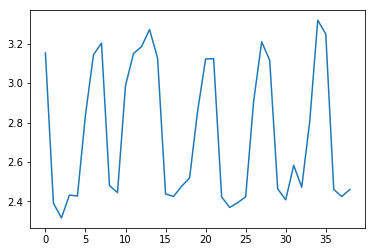

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.793952   
air_0164b9927d20bcc3_2017-04-23              1.418287   
air_0241aa3964b7f861_2017-04-23              2.367233   
air_0328696196e46f18_2017-04-23              2.161122   
air_034a3d5b40d5b1b1_2017-04-23              3.559620   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.013172  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.130040  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.667831  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.680874  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  34.149837

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l3_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')